In [1]:
import pandas as pd
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
MatchEventInfo = pd.read_parquet('../Cleaned_data/MatchEventInfo.parquet')
MatchVotesInfo = pd.read_parquet('../Cleaned_data/MatchVotesInfo.parquet')
MatchTournamentInfo = pd.read_parquet('../Cleaned_data/MatchTournamentInfo.parquet')
MatchSeasonInfo = pd.read_parquet('../Cleaned_data/MatchSeasonInfo.parquet')
MatchVenueInfo = pd.read_parquet('../Cleaned_data/MatchVenueInfo.parquet')
MatchAwayTeamInfo = pd.read_parquet('../Cleaned_data/MatchAwayTeamInfo.parquet')
MatchAwayScoreInfo = pd.read_parquet('../Cleaned_data/MatchAwayScoreInfo.parquet')
MatchRoundInfo = pd.read_parquet('../Cleaned_data/MatchRoundInfo.parquet')
MatchHomeScoreInfo = pd.read_parquet('../Cleaned_data/MatchHomeScoreInfo.parquet')
MatchHomeTeamInfo = pd.read_parquet('../Cleaned_data/MatchHomeTeamInfo.parquet')
PowerInfo = pd.read_parquet('../Cleaned_data/PowerInfo.parquet')
GameInfo = pd.read_parquet('../Cleaned_data/GameInfo.parquet')
OddsInfo = pd.read_parquet('../Cleaned_data/OddsInfo.parquet')
TimeInfo = pd.read_parquet('../Cleaned_data/TimeInfo.parquet')
PeriodInfo = pd.read_parquet('../Cleaned_data/PeriodInfo.parquet')

# Q_1

In [3]:
away_players = MatchAwayTeamInfo[['player_id','gender']]
home_players = MatchHomeTeamInfo[['player_id','gender']]
players = pd.concat([away_players,home_players])
players.drop_duplicates(inplace=True)
print(f'Number of Players in the dataset: {len(players)}')

Number of Players in the dataset: 2352


## Q 1.1 Additional

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


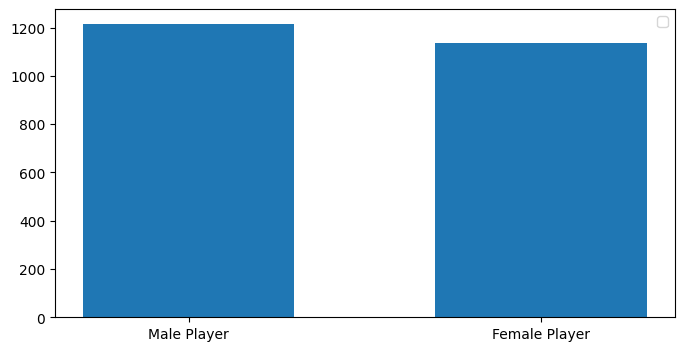

In [4]:
# we are going to calculate the distribution of male and femal players in case of number.
male_players = players[players['gender'].eq('M')]
female_players = players[players['gender'].eq('F')]
plt.figure(figsize=(8,4))
plt.bar(['Male Player','Female Player'],[male_players.shape[0],female_players.shape[0]],width=0.6)
plt.legend()
plt.show()

In [ ]:
gender_counts = players['gender'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(gender_counts, explode=(.1,0),labels=gender_counts.index,
        colors=['lightblue','lightpink'],autopct='%1.1f%%', startangle=140)
plt.legend()
plt.show()

# Q_2

In [5]:
away_players = MatchAwayTeamInfo[['player_id','gender','height']]
home_players = MatchHomeTeamInfo[['player_id','gender','height']]
players = pd.concat([away_players,home_players])
players.drop_duplicates(subset=['player_id'],inplace=True)
players_height_mean = round(players['height'].mean(), 3)
male_players_height_mean = round(players.loc[players['gender'].eq('M'),'height'].mean(), 3)
female_players_height_mean = round(players.loc[players['gender'].eq('F'),'height'].mean(), 3)
print(f'All players height average: {players_height_mean}')
print(f'Male players height average: {male_players_height_mean}')
print(f'Female players height average: {female_players_height_mean}')

All players height average: 1.82
Male players height average: 1.837
Female players height average: 1.801


# Q_3

To finde the winner based on GameInfo dataframe these steps must be taken:
<ol>
    <li>Determine points won by each team in each game</li>
    <li>Aggregate points to determine the game winner</li>
    <li>Aggregate games to determine the set winner</li>
    <li> Determine the match winner</li>
</ol>

In [6]:
# Step 1: 
GameInfo['home_game_win'] = GameInfo['home_score'] > GameInfo['away_score']
GameInfo['away_game_win'] = GameInfo['away_score'] > GameInfo['home_score']

# Step 2: 
game_winners = GameInfo.groupby(['match_id', 'set_id', 'game_id']).agg(
    home_game_wins=('home_game_win', 'sum'),
    away_game_wins=('away_game_win', 'sum')
).reset_index()

# Determine game winners (1 for home, -1 for away)
game_winners['game_winner'] = game_winners.apply(
    lambda row: 1 if row['home_game_wins'] > row['away_game_wins'] else -1, axis=1
)

# Step 3: 
set_winners = game_winners.groupby(['match_id', 'set_id']).agg(
    total_home_game_wins=('game_winner', lambda x: (x == 1).sum()),
    total_away_game_wins=('game_winner', lambda x: (x == -1).sum())
).reset_index()

# Determine set winners (1 for home, -1 for away)
set_winners['set_winner'] = set_winners.apply(
    lambda row: 1 if row['total_home_game_wins'] > row['total_away_game_wins'] else -1, axis=1
)

# Step 4:
match_winners = set_winners.groupby('match_id').agg(
    total_home_set_wins=('set_winner', lambda x: (x == 1).sum()),
    total_away_set_wins=('set_winner', lambda x: (x == -1).sum())
).reset_index()

# Determine match winners (Home or Away)
match_winners['match_winner'] = match_winners.apply(
    lambda row: 'Home' if row['total_home_set_wins'] > row['total_away_set_wins'] else 'Away', axis=1
)
match_winners.drop(['total_home_set_wins','total_away_set_wins'], axis=1, inplace=True)

In [7]:
def get_winner_playerid(row):
    match_id = row['match_id']
    match_winner = row['match_winner']
    if match_winner == 'Away':
        player_id = MatchAwayTeamInfo.loc[MatchAwayTeamInfo['match_id'].eq(match_id), 'player_id']
    elif match_winner == 'Home':
        player_id = MatchHomeTeamInfo.loc[MatchHomeTeamInfo['match_id'].eq(match_id), 'player_id']
    else:
        return None
    
    if len(player_id) > 0:
        return player_id.values[0]
    else:
        return None

match_winners['winner_player_id'] = match_winners.apply(lambda row: get_winner_playerid(row), axis=1)

In [8]:
higest_number_of_wins= match_winners['winner_player_id'].value_counts()
player_id_highest_win = higest_number_of_wins.index[0]
number_of_wins = higest_number_of_wins.iloc[0]
full_name = MatchAwayTeamInfo.loc[MatchAwayTeamInfo['player_id'].eq(player_id_highest_win),'full_name'].unique()
print(f'Player with most win is {full_name} with {number_of_wins} wins')

Player with most win is ['Sun, Fajing'] with 15 wins


# Q_4

In [9]:
def sum_periods(row):
    return row[row != 0].sum()

TimeInfo['sum_periods'] = (TimeInfo[['period_1', 'period_2', 'period_3', 'period_4', 'period_5']].apply(sum_periods,axis=1))

In [10]:
match_id_sum = TimeInfo[['match_id','sum_periods']]
match_id_sum.sort_values(by='sum_periods',ascending=False)

,match_id,sum_periods
6310,12346747,171153.0
897,12300269,165040.0
4739,12336297,162704.0
6992,12357962,154877.0
4145,12330588,137640.0
...,...,...
4672,12334984,10.0
2197,12311868,10.0
2057,12311067,9.0
179,12291498,8.0


# Q_5

In [11]:
GameInfo

,match_id,set_id,game_id,point_id,home_point,away_point,point_description,home_point_type,away_point_type,home_score,away_score,serving,scoring,home_game_win,away_game_win
0,12260075,2,10,0,15,0,0,1,5,4,6,2,2,False,True
1,12260075,2,10,1,15,15,0,5,1,4,6,2,2,False,True
2,12260075,2,10,2,15,30,0,5,1,4,6,2,2,False,True
3,12260075,2,10,3,15,40,0,5,3,4,6,2,2,False,True
4,12260075,2,9,0,15,0,1,1,5,4,5,1,1,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749512,12385017,1,2,8,40,A,0,5,1,1,1,2,2,False,False
749513,12385017,1,1,0,15,0,0,1,5,1,0,1,1,True,False
749514,12385017,1,1,1,30,0,0,1,5,1,0,1,1,True,False
749515,12385017,1,1,2,30,15,0,5,1,1,0,1,1,True,False


In [12]:
most_played_sets = GameInfo.groupby('set_id').agg({'match_id':'nunique'}).reset_index()
most_played_sets

,set_id,match_id
0,1,6555
1,2,6453
2,3,1949
3,4,49
4,5,20


In [13]:
perc_set_3 = most_played_sets.iloc[2,1] / most_played_sets.iloc[0,1]
perc_set_4 = most_played_sets.iloc[3,1] / most_played_sets.iloc[0,1]
perc_set_5 = most_played_sets.iloc[4,1] / most_played_sets.iloc[0,1]
print(f'{round(perc_set_3 * 100, 2)}% of matches reached the third set.')
print(f'{round(perc_set_4 * 100, 2)}% of matches reached the fourth set.')
print(f'{round(perc_set_5 * 100, 2)}% of matches reached the fifth set.')

29.73% of matches reached the third set.
0.75% of matches reached the fourth set.
0.31% of matches reached the fifth set.


This Analysis shows that two set is the minmume set that are palyed in a tennis game, 3rd set occurs aroudn 30 percent of matches and fourth and fifth set only happend in 0.75 percent and 0.31. 

# Q_6

The Metric that i use to identify the most successful players is their current rank.

In [15]:
player_away = MatchAwayTeamInfo[['player_id', 'full_name', 'gender', 'current_rank', 'country']]
player_home = MatchHomeTeamInfo[['player_id', 'full_name', 'gender','current_rank', 'country']]
players = pd.concat([player_away,player_home],axis=0)
players.head()

,player_id,full_name,gender,current_rank,country
0,254742,"Lehečka, Jiří",M,24.0,Czech Republic
1,90080,"Khachanov, Karen",M,18.0,Russia
2,275923,"Alcaraz, Carlos",M,3.0,Spain
3,275923,"Alcaraz, Carlos",M,3.0,Spain
4,57163,"Zverev, Alexander",M,4.0,Germany


In [16]:
#I consider the most successful players up to rank 100
top_100 = players.query('0 < current_rank <=100')
top_100 = top_100.drop_duplicates()
male_top_100 = top_100[top_100['gender'].eq('M')]
female_top_100 = top_100[top_100['gender'].eq('F')]

In [17]:
countries_male_top_100 = (male_top_100.
                          groupby('country').
                          agg(num_of_players =('player_id','count')).
                          reset_index()).sort_values(by='num_of_players', ascending=False)
countries_female_top_100 = (female_top_100.
                            groupby('country').
                            agg(num_of_players =('player_id','count')).
                            reset_index()).sort_values(by='num_of_players', ascending=False)


In [18]:
countries_male_top_100.head(10)

,country,num_of_players
29,USA,23
18,Italy,22
13,France,19
1,Australia,18
0,Argentina,15
27,Spain,14
14,Germany,12
25,Russia,11
26,Serbia,8
30,United Kingdom,8


In [19]:
countries_female_top_100.head(10)

,country,num_of_players
29,USA,29
24,Russia,25
7,China,16
17,Italy,11
13,France,11
10,Czech Republic,10
30,Ukraine,8
26,Spain,8
0,Argentina,7
23,Romania,6


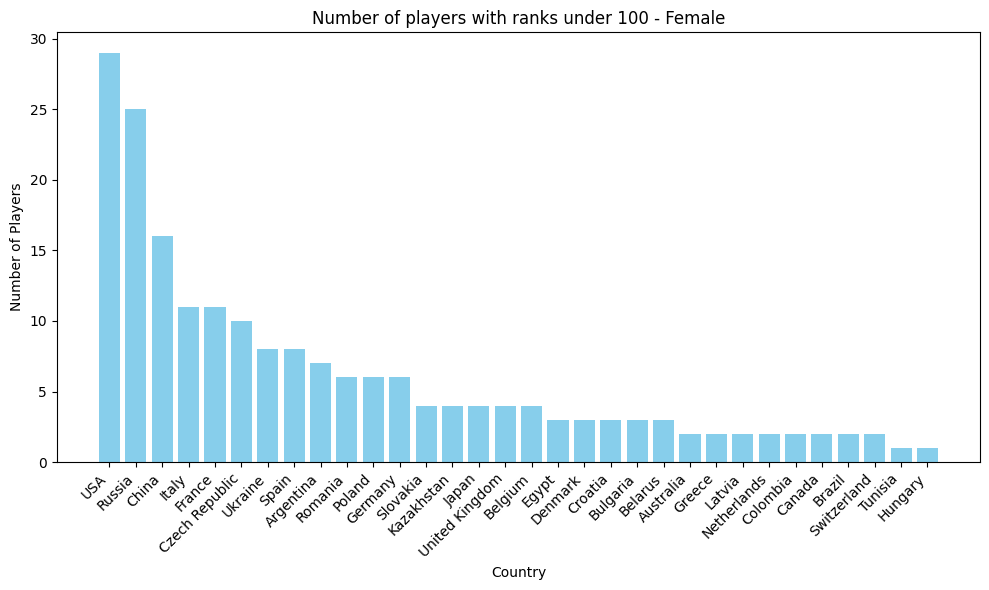

In [20]:
plt.figure(figsize=(10, 6))
plt.bar(countries_female_top_100['country'], countries_female_top_100['num_of_players'], color='skyblue')
plt.title('Number of players with ranks under 100 - Female')
plt.xlabel('Country')
plt.ylabel('Number of Players')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

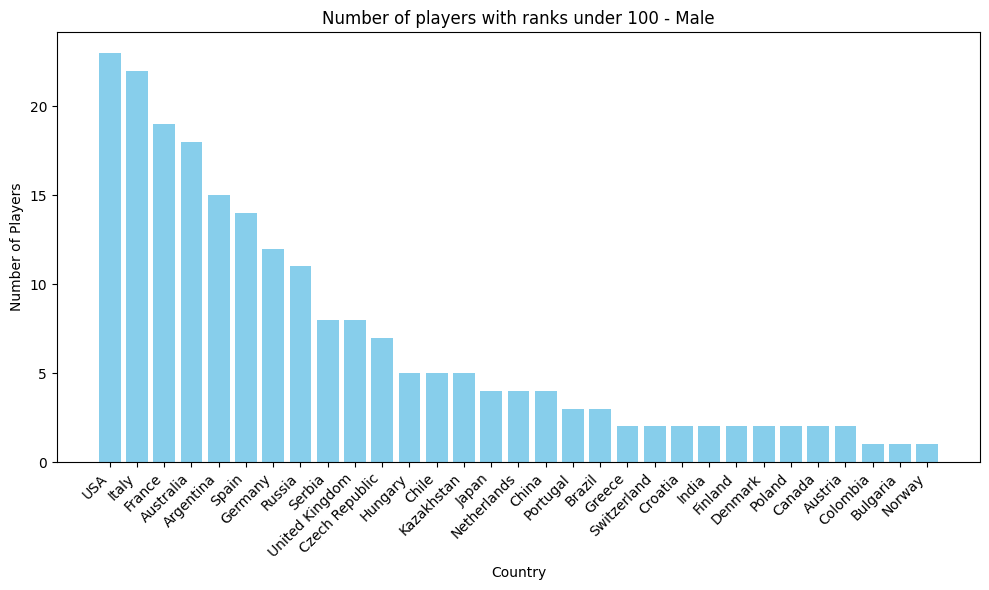

In [21]:
plt.figure(figsize=(10, 6))
plt.bar(countries_male_top_100['country'], countries_male_top_100['num_of_players'], color='skyblue')
plt.title('Number of players with ranks under 100 - Male')
plt.xlabel('Country')
plt.ylabel('Number of Players')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Q_7

In [22]:
PeriodInfo.head()

,match_id,period,statistic_category_name,statistic_name,home_stat,away_stat,compare_code,statistic_type,value_type,home_value,away_value,home_total,away_total
0,12260075,ALL,service,aces,2,7,2,positive,event,0,0,164.0,164.0
1,12260075,ALL,service,double_faults,2,1,1,negative,event,0,0,164.0,164.0
2,12260075,ALL,service,first_serve,44/72 (61%),48/65 (74%),2,positive,team,14,60,72.0,65.0
3,12260075,ALL,service,second_serve,26/28 (93%),16/17 (94%),2,positive,team,32,14,28.0,17.0
4,12260075,ALL,service,first_serve_points,30/44 (68%),42/48 (88%),2,positive,team,44,58,44.0,48.0


In [23]:
sum_of_aces = (
    PeriodInfo.loc[PeriodInfo['statistic_name'].
                   eq('aces')].
                   groupby('match_id').
                   size().
                   reset_index(name='Count_Aces')
                   
)

In [24]:
sum_of_aces

,match_id,Count_Aces
0,12260075,3
1,12260076,4
2,12260077,4
3,12260078,4
4,12260080,3
...,...,...
6792,12384975,4
6793,12385017,4
6794,12385869,3
6795,12385873,3


In [25]:
mean_of_aces_per_match = sum_of_aces['Count_Aces'].mean()
print(f'Average number of aces per match is {mean_of_aces_per_match}')

Average number of aces per match is 3.275121377078123


# Q_8

In [26]:
PeriodInfo_subset = PeriodInfo.loc[PeriodInfo['statistic_name'].eq('double_faults'),('match_id', 'statistic_name',)]

In [35]:
double_faults_count = PeriodInfo_subset.groupby('match_id').agg({'statistic_name': 'count'}).reset_index()
double_faults_count.rename(columns={'statistic_name': 'Double_Faults'}, inplace=True)

In [36]:
match_gender_home = MatchHomeTeamInfo[['match_id', 'gender']]
match_gender_away = MatchAwayTeamInfo[['match_id', 'gender']]
match_gender = pd.concat([match_gender_away,match_gender_home]).drop_duplicates()
double_fault_gender = pd.merge(double_faults_count, match_gender, on='match_id', how='left')

Since there is no information in the MatchAwayTeamInfo, MatchHomeTeamInfo of match_id with geneder= Nan, i have no other choice to drop null values.

In [37]:
double_fault_gender = double_fault_gender.dropna()

In [38]:
double_fault_gender

,match_id,Double_Faults,gender
0,12260075,3,M
1,12260076,4,M
2,12260077,4,M
3,12260078,4,M
4,12260080,3,M
...,...,...,...
6792,12384975,4,F
6793,12385017,4,F
6794,12385869,3,M
6795,12385873,3,M


In [39]:
double_fault_gender.groupby('gender').agg({'Double_Faults':['mean','median']})

Double_Faults       
                mean median
gender                     
F           3.258797    3.0
M           3.296579    3.0

This analysis shows there is no significant difference between men and women in the occurrence of double faults.

In [40]:
# Now, T-test will be used to confirm our foundings
male_double_faults = double_fault_gender[double_fault_gender['gender'].eq('M')]['Double_Faults']
female_double_faults = double_fault_gender[double_fault_gender['gender'].eq('M')]['Double_Faults']

In [41]:
t_stat, p_value = stats.ttest_ind(male_double_faults,female_double_faults)
print(f"T-test statistic: {t_stat}")
print(f"P-value: {p_value}")

T-test statistic: 0.0
P-value: 1.0


p-value of 1.0 strongly supports the null hypothesis which suggesting that there is no statistically significant difference in the occurrence of double faults between men and women.

# Q_9

To finde the winner based on GameInfo dataframe these steps must be taken:
<ol>
    <li>Determine points won by each team in each game</li>
    <li>Aggregate points to determine the game winner</li>
    <li>Aggregate games to determine the set winner</li>
    <li> Determine the match winner</li>
</ol>

In [42]:
# Step 1: 
GameInfo['home_game_win'] = GameInfo['home_score'] > GameInfo['away_score']
GameInfo['away_game_win'] = GameInfo['away_score'] > GameInfo['home_score']

# Step 2: 
game_winners = GameInfo.groupby(['match_id', 'set_id', 'game_id']).agg(
    home_game_wins=('home_game_win', 'sum'),
    away_game_wins=('away_game_win', 'sum')
).reset_index()

# Determine game winners (1 for home, -1 for away)
game_winners['game_winner'] = game_winners.apply(
    lambda row: 1 if row['home_game_wins'] > row['away_game_wins'] else -1, axis=1
)

# Step 3: 
set_winners = game_winners.groupby(['match_id', 'set_id']).agg(
    total_home_game_wins=('game_winner', lambda x: (x == 1).sum()),
    total_away_game_wins=('game_winner', lambda x: (x == -1).sum())
).reset_index()

# Determine set winners (1 for home, -1 for away)
set_winners['set_winner'] = set_winners.apply(
    lambda row: 1 if row['total_home_game_wins'] > row['total_away_game_wins'] else -1, axis=1
)

# Step 4:
match_winners = set_winners.groupby('match_id').agg(
    total_home_set_wins=('set_winner', lambda x: (x == 1).sum()),
    total_away_set_wins=('set_winner', lambda x: (x == -1).sum())
).reset_index()

# Determine match winners (Home or Away)
match_winners['match_winner'] = match_winners.apply(
    lambda row: 'Home' if row['total_home_set_wins'] > row['total_away_set_wins'] else 'Away', axis=1
)
match_winners.drop(['total_home_set_wins','total_away_set_wins'], axis=1, inplace=True)

In [43]:
def get_winner_playerid(row):
    match_id = row['match_id']
    match_winner = row['match_winner']
    if match_winner == 'Away':
        player_id = MatchAwayTeamInfo.loc[MatchAwayTeamInfo['match_id'].eq(match_id), 'player_id']
    elif match_winner == 'Home':
        player_id = MatchHomeTeamInfo.loc[MatchHomeTeamInfo['match_id'].eq(match_id), 'player_id']
    else:
        return None
    
    if len(player_id) > 0:
        return player_id.values[0]
    else:
        return None

match_winners['winner_player_id'] = match_winners.apply(lambda row: get_winner_playerid(row), axis=1)

In [44]:
tournament_subset = MatchTournamentInfo[['match_id','tournament_id','tournament_name']]
# i can find the winner of each tournament that has info in GameInfo dataframe
match_winners_tournament = pd.merge(match_winners, tournament_subset, on='match_id', how='left')

In [45]:
""" we group dataframe by ['tournament_id', 'tournament_name', 'winner_player_id'] 
to count one player how many times won in a tournament """
tournament_winners = (match_winners_tournament.
                      groupby(['tournament_id', 'tournament_name', 'winner_player_id']).
                      size().
                      reset_index(name='win_count'))

"""Now first we sort bu tournament_id in ascending order and win_count in descending order, 
then grouped the data using ['tournament_id', 'tournament_name'] 
and get only the first rows for each tournament
"""
tournament_winners = (tournament_winners.sort_values(['tournament_id', 'win_count'], 
                                                    ascending=[True, False]) \
                      .groupby(['tournament_id', 'tournament_name']).
                      first().
                      reset_index())
tournament_winners

,tournament_id,tournament_name,winner_player_id,win_count
0,129164,"Madrid, Spain",106755.0,3
1,129201,"Madrid, Spain",157754.0,3
2,129510,"Guangzhou, China",226805.0,3
3,129514,"Porto Alegre, Brazil",38180.0,3
4,129518,"Aix en Provence, France",102151.0,3
...,...,...,...,...
256,131092,"Kingston, Singles Main, M-ITF-JAM-03A",207606.0,3
257,131095,"Rio Claro, Singles Main, W-ITF-BRA-06A",120664.0,4
258,131098,"San Diego, CA, Singles Main, M-ITF-USA-11A",52057.0,3
259,131100,"San Diego, CA, Singles Main, W-ITF-USA-17A",152106.0,3


In [46]:
most_tournament_winner = (tournament_winners.
                          groupby('winner_player_id').
                          agg(num_tournament_won=('tournament_id','count')).
                          reset_index().
                          sort_values(by='num_tournament_won', ascending=False)
                         )

max_wins = most_tournament_winner['num_tournament_won'].max()
top_winners = most_tournament_winner[most_tournament_winner['num_tournament_won'].eq(max_wins)]

In [47]:
top_winners_name =pd.merge(top_winners,MatchAwayTeamInfo[['player_id','full_name']], left_on='winner_player_id',
         right_on='player_id', how='left').drop_duplicates()

In [48]:
top_winners_name

,winner_player_id,num_tournament_won,player_id,full_name
0,14823.0,3,14823,"Gabashvili, Teimuraz"
9,15983.0,3,15983,"Kližan, Martin"
16,163438.0,3,163438,"Sun, Fajing"
